In [2]:
# Install required packges
!pip -qq install split-folders tqdm timm
!pip install -qq pytorch-metric-learning[with-hooks]

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import glob
import cv2
import splitfolders
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

import os
import shutil
import glob
import pandas as pd
import numpy as np
import logging
import timm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import Compose, Lambda, Normalize, AutoAugment, AutoAugmentPolicy, Resize

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as LP
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import InferenceModel

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

import cv2
import splitfolders

from sklearn.metrics import (confusion_matrix, 
                             balanced_accuracy_score, 
                             average_precision_score, 
                             f1_score, 
                             roc_auc_score,
                             silhouette_score)
import seaborn as sns
from sklearn.manifold import TSNE
import itertools

from sklearn.cluster import KMeans, OPTICS, DBSCAN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

INFO:root:VERSION 1.6.2


# Data analysis
* See this section in main notebook

## Solution #2
Arcface + Boosting

Motivation:  The [metric learning techniques](https://hav4ik.github.io/articles/deep-metric-learning-survey) will probably perform better than tha classic CNN as they tend to separate clusters as much as possible.

[source #2](https://towardsdatascience.com/the-why-and-the-how-of-deep-metric-learning-e70e16e199c0)

## Prepare data

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
splitfolders.fixed("../input/bj-demo/images", output="/kaggle/temp/trainval_test", oversample=False,
    seed=42, fixed=8, group_prefix=None, move=False)
!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

Copying files: 1422 files [00:07, 194.55 files/s]


## Parameters

In [6]:
MODEL_NAME='tf_efficientnet_b6_ns'
N_CLASSES=8
OUTPUT_SIZE = 2304
EMBEDDING_SIZE = 512
N_EPOCH=10
BATCH_SIZE=8
ACCUMULATION_STEPS = int(256 / BATCH_SIZE)
MODEL_LR = 1e-3
PCT_START=0.3
PATIENCE=5
N_WORKER=2
N_NEIGHBOURS = 750

LABEL_DICT = {"ArtDeco":0,
              "Cubism":1,
              "Impressionism":2,
              "Japonism":3,
              "Naturalism":4,
              "Rococo":5,
              "cartoon":6,
              "photo":7}


## Directories

In [7]:
TRAIN_DIR = "/kaggle/temp/trainval"
TEST_DIR = "/kaggle/temp/test"
LOG_DIR = "../logs/{}".format(MODEL_NAME)
MODEL_DIR = "../models/{}".format(MODEL_NAME)

## Dataset

In [8]:
class PictureDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        image_dir: str,
        return_labels=True,
    ):
        self.df = df
        self.images = self.df["image"]
        self.image_dir = image_dir
        self.image_transform = Compose(
            [
                Resize((384,384)),
                AutoAugment(AutoAugmentPolicy.IMAGENET),
                Lambda(lambda x: x / 255),
            ]
        )
        self.return_labels = return_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, self.images.iloc[idx])
        image = read_image(path=image_path)
        image = self.image_transform(image)
        
        if self.return_labels:
            label = self.df['label'].iloc[idx]
            return image, label
        else:
            return image

## Data Split


In [9]:
file_paths = glob.glob(os.path.join(TRAIN_DIR, "*/*.jpg"))
file_labels = [x.split("/")[4] for x in file_paths]
df = pd.DataFrame({"image":file_paths, "individual_id":file_labels})
df['label'] = df.groupby('individual_id').ngroup()
df['label'].describe()
df.head()

,image,individual_id,label
0,/kaggle/temp/trainval/Cubism/aleksandra-ekster...,Cubism,1
1,/kaggle/temp/trainval/Cubism/carlos-merida_fac...,Cubism,1
2,/kaggle/temp/trainval/Cubism/jury-annenkov_por...,Cubism,1
3,/kaggle/temp/trainval/Cubism/man-ray_untitled-...,Cubism,1
4,/kaggle/temp/trainval/Cubism/gosta-adrian-nils...,Cubism,1


In [10]:
valid_proportion = 0.05

valid_df = df.sample(frac=valid_proportion, replace=False, random_state=1).copy()
train_df = df[~df['image'].isin(valid_df['image'])].copy()
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [11]:
train_dataset = PictureDataset(df=train_df, image_dir=TRAIN_DIR, return_labels=True)
valid_dataset = PictureDataset(df=valid_df, image_dir=TRAIN_DIR, return_labels=True)
len(valid_dataset), len(train_dataset)

(68, 1290)

In [12]:
dataset_dict = {"train": train_dataset, "val": valid_dataset}

## Model Setup
We need to specify three components to build our model:

- Trunk
- Embedder
- Loss

In [13]:
trunk = timm.create_model(MODEL_NAME, pretrained=True)
trunk.classifier = common_functions.Identity()
trunk = trunk.to(device)
trunk_optimizer = optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
trunk_schedule = optim.lr_scheduler.OneCycleLR(
    trunk_optimizer,
    max_lr=MODEL_LR,
    total_steps = N_EPOCH * int(len(train_dataset)/BATCH_SIZE),
    pct_start = PCT_START
)

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_ns-51548356.pth


In [14]:
embedder = nn.Linear(OUTPUT_SIZE, EMBEDDING_SIZE).to(device)
embedder_optimizer = optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
embedder_schedule = optim.lr_scheduler.OneCycleLR(
    embedder_optimizer,
    max_lr=MODEL_LR,
    total_steps = N_EPOCH * int(len(train_dataset)/BATCH_SIZE),
    pct_start = PCT_START
)

In [15]:
loss_func = losses.ArcFaceLoss(num_classes=N_CLASSES, embedding_size=EMBEDDING_SIZE).to(device)
loss_optimizer = optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
loss_schedule = optim.lr_scheduler.OneCycleLR(
    loss_optimizer,
    max_lr=MODEL_LR,
    total_steps = N_EPOCH * int(len(train_dataset)/BATCH_SIZE),
    pct_start = PCT_START
)

In [16]:
# Metrics
record_keeper, _, _ = LP.get_record_keeper(LOG_DIR)
hooks = LP.get_hook_container(record_keeper, primary_metric='mean_average_precision')

In [17]:
# Testing algorithm (metrics and Early Stopping callback)
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    accuracy_calculator=AccuracyCalculator(
        include=['mean_average_precision'],
        device=torch.device("cpu"),
        k=5),
    dataloader_num_workers=N_WORKER,
    batch_size=BATCH_SIZE
)

By adding the tester as an end of epoch hook in this way, it will automatically use the embedder model to generate train and validation embeddings, then for each validation embedding find the k nearest neighbours and evaluate MAP@5. This won't take into account the `new_individual` problem, but it should give us an idea of model performance on the task regardless.

In [18]:
end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, 
    dataset_dict,
    MODEL_DIR,
    test_interval=1, 
    patience=PATIENCE, 
    splits_to_eval = [('val', ['train'])]
)

Extend the `MetricLossOnly` class to include gradient accumulation and mixed precision training: 

In [19]:
class PictureTrainer(trainers.MetricLossOnly):
    def __init__(self, *args, accumulation_steps=10, **kwargs):
        super().__init__(*args, **kwargs)
        self.accumulation_steps = accumulation_steps

    def forward_and_backward(self):
        self.zero_losses()
        self.update_loss_weights()
        self.calculate_loss(self.get_batch())
        self.loss_tracker.update(self.loss_weights)
        self.backward()
        self.clip_gradients()
        if ((self.iteration + 1) % self.accumulation_steps == 0) or ((self.iteration + 1) == np.ceil(len(self.dataset) / self.batch_size)):
            self.step_optimizers()
            self.zero_grad()
            
    def calculate_loss(self, curr_batch):
        data, labels = curr_batch
        with torch.cuda.amp.autocast():
            embeddings = self.compute_embeddings(data)
            indices_tuple = self.maybe_mine_embeddings(embeddings, labels)
            self.losses["metric_loss"] = self.maybe_get_metric_loss(
                embeddings, labels, indices_tuple
            )

# Trainer

In [20]:
trainer = PictureTrainer(
    models={"trunk": trunk, "embedder": embedder},
    optimizers={"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer, "metric_loss_optimizer": loss_optimizer},
    batch_size=BATCH_SIZE,
    loss_funcs={"metric_loss": loss_func},
    mining_funcs={},
    dataset=train_dataset,
    dataloader_num_workers=N_WORKER,
    end_of_epoch_hook=end_of_epoch_hook,
    lr_schedulers={
        'trunk_scheduler_by_iteration': trunk_schedule,
        'embedder_scheduler_by_iteration': embedder_schedule,
        'metric_loss_scheduler_by_iteration': loss_schedule,
    },
    accumulation_steps=ACCUMULATION_STEPS
)

## Model Training

In [21]:
trainer.train(num_epochs=N_EPOCH)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=35.19590:   0%|          | 0/161 [00:07<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
total_loss=29.31691: 100%|██████████| 161/161 [01:14<00:00,  2.17it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|██████████| 9/9 [00:01<00:00,  6.10it/s]
INFO:PML:Getting embeddings for the train split
100%|█

## Inference (validation set)

Here we want to use the validation set to help us choose the appropriate distance threshold between our query and reference images after which we classify the former as a new_individual. To do so, we loop through the validation set for a number of thresholds and find that which maximises our MAP@5.

Load in the best weights:

In [22]:
logging.getLogger().setLevel(logging.WARNING)

In [23]:
best_trunk_weights = glob.glob('../models/{}/trunk_best*.pth'.format(MODEL_NAME))[0]
shutil.copy(best_trunk_weights, "/kaggle/working/best_trunk.pth")
trunk.load_state_dict(torch.load(best_trunk_weights))

<All keys matched successfully>

In [24]:
best_embedder_weights = glob.glob('../models/{}/embedder_best*.pth'.format(MODEL_NAME))[0]
shutil.copy(best_embedder_weights, "/kaggle/working/best_embedder.pth")
embedder.load_state_dict(torch.load(best_embedder_weights))

<All keys matched successfully>

Setup the inference model object to easily generate embeddings and find nearest neighbours:

In [25]:
inference_model = InferenceModel(
    trunk=trunk,
    embedder=embedder,
    normalize_embeddings=True,
)

Train this on the training data:

In [26]:
inference_model.train_knn(train_dataset)

Loop through the validation data and loop through to find k nearest neighbours:

In [27]:
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKER, pin_memory=True)

In [28]:
valid_labels_list = []
valid_distance_list = []
valid_indices_list = []

for images, labels in tqdm(valid_dataloader):

    distances, indices = inference_model.get_nearest_neighbors(images, k=N_NEIGHBOURS)
    valid_labels_list.append(labels)
    valid_distance_list.append(distances)
    valid_indices_list.append(indices)

valid_labels = torch.cat(valid_labels_list, dim=0).cpu().numpy()
valid_distances = torch.cat(valid_distance_list, dim=0).cpu().numpy()
valid_indices = torch.cat(valid_indices_list, dim=0).cpu().numpy()

  0%|          | 0/9 [00:00<?, ?it/s]

We have the indices of the nearest neighbours in our training set, so setup the lookups to return the `individual_id`:

In [29]:
new_pic_idx = -1

train_labels = train_df['individual_id'].unique()
train_idx_lookup = train_df['individual_id'].copy().to_dict()
train_idx_lookup[-1] = 'new_individual'

valid_class_lookup = valid_df.set_index('label')['individual_id'].copy().to_dict()

Loop through a range of thresholds and find which maximises our MAP@5:

In [30]:
thresholds = [np.quantile(valid_distances, q=q) for q in np.arange(0, 1.0, 0.01)]

In [31]:
results = []

for threshold in tqdm(thresholds):

    prediction_list = []
    running_map=0

    for i in range(len(valid_distances)):

        pred_knn_idx = valid_indices[i, :].copy()  
        insert_idx = np.where(valid_distances[i, :] > threshold) 

        if insert_idx[0].size != 0:  
            pred_knn_idx = np.insert(pred_knn_idx, np.min(insert_idx[0]), new_pic_idx) 

        predicted_label_list = []
        
        for predicted_idx in pred_knn_idx:
            predicted_label = train_idx_lookup[predicted_idx]
            if len(predicted_label_list) == 5:
                break
            if (predicted_label == 'new_individual') | (predicted_label not in predicted_label_list):
                predicted_label_list.append(predicted_label)

        gt = valid_class_lookup[valid_labels[i]]

        if gt not in train_labels:
            gt = "new_individual"

        precision_vals = []

        for j in range(5):
            if predicted_label_list[j] == gt:
                precision_vals.append(1/(j+1))
            else:
                precision_vals.append(0)

        running_map += np.max(precision_vals)

    results.append([threshold, running_map / len(valid_distances)])

results_df = pd.DataFrame(results, columns=['threshold','map5'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
results_df = results_df.sort_values(by='map5', ascending=False).reset_index(drop=True)
results_df.head(5)

,threshold,map5
0,1.409117,0.727451
1,1.789231,0.727451
2,1.760480,0.727451
3,1.744778,0.727451
4,1.728765,0.727451


Grab the best result:

In [33]:
threshold = results_df.loc[0, 'threshold']
threshold

1.4091167449951172

## Inference (test set)

We want to make sure we use both our training and validation images for comparison. Combine the two dataframes and add a new dataset:

In [34]:
combined_df = pd.concat([train_df, valid_df], axis=0).reset_index(drop=True)
combined_dataset = PictureDataset(df=combined_df, image_dir=TRAIN_DIR, return_labels=True)
len(combined_dataset)

1358

Re-train the KNN model on this:

In [35]:
inference_model.train_knn(combined_dataset)

In [36]:
file_paths = glob.glob(os.path.join(TEST_DIR, "*/*.jpg"))
file_labels = [x.split("/")[4] for x in file_paths]
test_df = pd.DataFrame({"image":file_paths, "individual_id":file_labels})
test_df.head()

,image,individual_id
0,/kaggle/temp/test/Cubism/johannes-sveinsson-kj...,Cubism
1,/kaggle/temp/test/Cubism/david-bomberg_racehor...,Cubism
2,/kaggle/temp/test/Cubism/aristarkh-lentulov_vi...,Cubism
3,/kaggle/temp/test/Cubism/henri-laurens_femme-a...,Cubism
4,/kaggle/temp/test/Cubism/paul-cezanne_bathers-...,Cubism


In [37]:
test_dataset = PictureDataset(df=test_df, image_dir=TEST_DIR, return_labels=False)
len(test_dataset)

64

In [38]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKER, pin_memory=True)

In [39]:
test_distance_list = []
test_indices_list = []

for images in tqdm(test_dataloader):

    distances, indices = inference_model.get_nearest_neighbors(images, k=N_NEIGHBOURS)
    test_distance_list.append(distances)
    test_indices_list.append(indices)

test_distances = torch.cat(test_distance_list, dim=0).cpu().numpy()
test_indices = torch.cat(test_indices_list, dim=0).cpu().numpy()

  0%|          | 0/8 [00:00<?, ?it/s]

In [40]:
combined_idx_lookup = combined_df['individual_id'].copy().to_dict()
combined_idx_lookup[-1] = 'outlier'

In [41]:
results = []

prediction_list = []

for i in range(len(test_distances)):

    pred_knn_idx = test_indices[i, :].copy() 
    insert_idx = np.where(test_distances[i, :] > threshold)  

    if insert_idx[0].size != 0:  
        pred_knn_idx = np.insert(pred_knn_idx, np.min(insert_idx[0]), new_pic_idx)  

    predicted_label_list = []

    for predicted_idx in pred_knn_idx:
        predicted_label = combined_idx_lookup[predicted_idx]
        if len(predicted_label_list) == 1:
            break
        if (predicted_label == 'outlier') | (predicted_label not in predicted_label_list):
            predicted_label_list.append(predicted_label)

    prediction_list.append(predicted_label_list)

prediction_df = pd.DataFrame(prediction_list)
prediction_df.head()

,0
0,Cubism
1,Cubism
2,Cubism
3,Japonism
4,Impressionism


In [42]:
test_df["prediction"] = prediction_df[0]

In [43]:
test_df.to_csv("/kaggle/working/preds.csv")

In [44]:
y_true = test_df["individual_id"].apply(lambda x: LABEL_DICT[x]).tolist()
y_pred = test_df["prediction"].apply(lambda x: LABEL_DICT[x]).tolist()

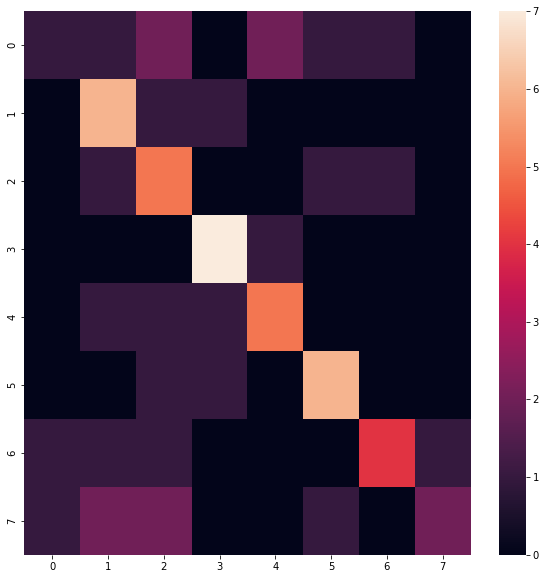

In [45]:
conf_matrix = confusion_matrix(y_true, y_pred, labels = [0,1,2,3,4,5,6,7])
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(conf_matrix)

In [49]:
balanced_accuracy_score(y_pred, y_true) # as we have an imbalanced test dataset

0.5678685897435898

In [50]:
f1_score(y_pred, y_true, average = "weighted")

0.5872832845259315

# Task 2

Here we generate embeddings and try to asess how good the classes are separated.

Another option is to try to cluster the embeddings and distinguish the outliers (see data analysis).

In [51]:
embedding_paths = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")

In [52]:
def get_feature(model, in_path):
    in_image = cv2.imread(in_path)
    prediction = None
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB))
        in_image = in_image.permute(2,0,1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.

#         prediction = model(in_image)
        prediction = model.get_embeddings(in_image)
    return torch.flatten(prediction).detach().cpu().numpy()

May be we did not need training above? 

The model, pretrained on imagenet, may give good results.

In [53]:
num_classes = len(os.listdir("/kaggle/input/bj-demo/images"))

In [54]:
embeddings = []
for emb_path in tqdm(embedding_paths):
    embeddings.append(get_feature(inference_model, emb_path))

  0%|          | 0/1422 [00:00<?, ?it/s]

In [55]:
embeddings_df = pd.DataFrame({"paths":embedding_paths, 
                              "embeddings":embeddings})

In [56]:
# Get nice projection of embeddings into 2d-space
embeddings_2d = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(np.array(embeddings))

In [57]:
embeddings_df["embeddings_2d"] = embeddings_2d.tolist()
embeddings_df["gt_label"] = embeddings_df["paths"].apply(lambda x: x.split("/")[5])

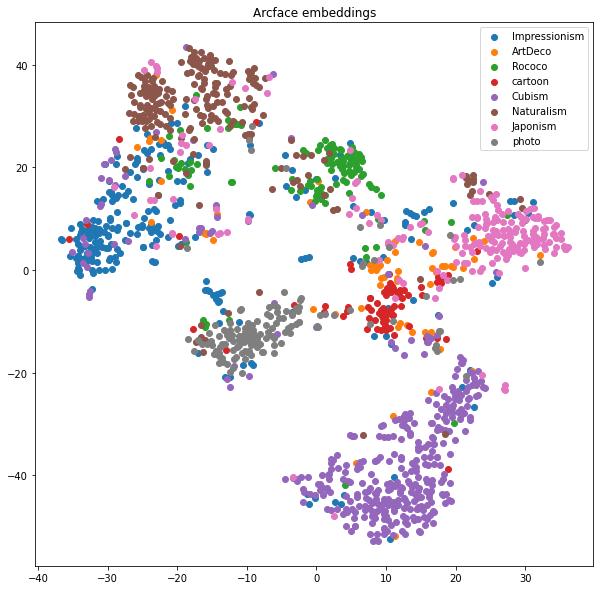

In [58]:
u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["gt_label"]==i]["embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["gt_label"]==i]["embeddings_2d"].tolist())[:,1] , 
                label = i)
plt.title("Arcface embeddings")
plt.legend()
plt.show()

Arcface can provide A LOT more effective embeddings, than conventional CNN

To asess the cluster quality we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

The score is calculated between two sets. Here we will find the score between every pair of classes.

! one-vs-all may be bad if the cluster is surrounded by others.

In [59]:
embeddings_df["gt_labelnum"] = embeddings_df["gt_label"].apply(lambda x: LABEL_DICT[x])


In [60]:
def calc_silhouette(classA:int, classB: int, df:pd.DataFrame, key: str) -> float:
    classA_df = embeddings_df[embeddings_df["gt_labelnum"] == classA]
    classB_df = embeddings_df[embeddings_df["gt_labelnum"] == classB]
    combined_df = pd.concat([classA_df,classB_df])
    return silhouette_score(combined_df[key].tolist(), combined_df["gt_labelnum"].tolist())

In [61]:
combinations_list = list(itertools.combinations(list(embeddings_df["gt_labelnum"].unique()), 2))
classes_A = []
classes_B = []
silhouette_list = []
for item in combinations_list:
    classes_A.append(item[0])
    classes_B.append(item[1])
    silhouette_list.append(calc_silhouette(item[0], item[1], embeddings_df, key = "embeddings"))
pretrained_silhouette_df = pd.DataFrame({"Class A": classes_A, "Class B": classes_B, "silhouette score": silhouette_list})

In [62]:
pretrained_silhouette_df

,Class A,Class B,silhouette score
0,2,0,0.150493
1,2,5,0.169831
2,2,6,0.204486
3,2,1,0.302738
4,2,4,0.229291
5,2,3,0.264383
6,2,7,0.277609
7,0,5,0.196474
8,0,6,0.111009
9,0,1,0.292492


The silhouette score is MUCH better than the one CNN

It would be nice to remove dataset noise. One solution is to use OPTICS algorithm.

I have tried to cluster embeddings with OPTICS, but surprisingly did not achieve good result. The problem may be in [curse of dimensionality](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb).

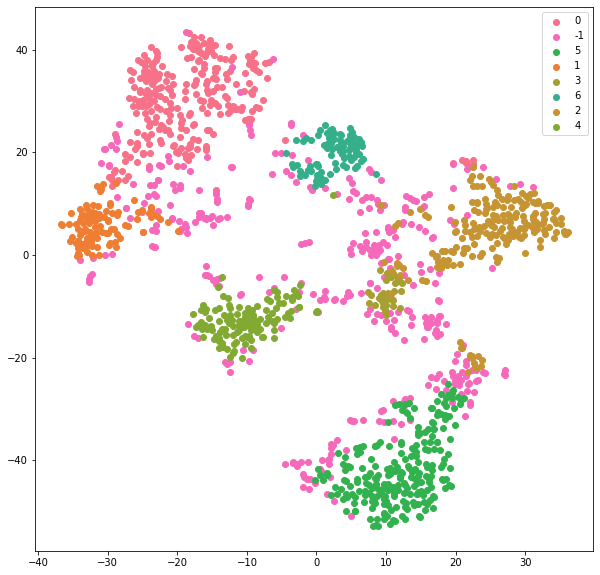

In [73]:
clusters = OPTICS(min_samples = 35, xi=1.e-50)
clusters.fit(embeddings)

embeddings_df["cluster_label"] = clusters.labels_

u_labels = embeddings_df["cluster_label"].unique()
rgb_values = sns.color_palette("husl", 14)
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["cluster_label"]==i]["embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["cluster_label"]==i]["embeddings_2d"].tolist())[:,1] , label = i, color=rgb_values[i])
plt.legend()
plt.show()

Here OPTICS works perfect even at original dimension size.

The clusters are similar to classes from labeling and we can clearly see the outliers.

The only problem is that we have "lost" the ArtDeco class. It is expected as during training it gave relatively bad results.

Lets try something more simple (as the clusters are well-seen)

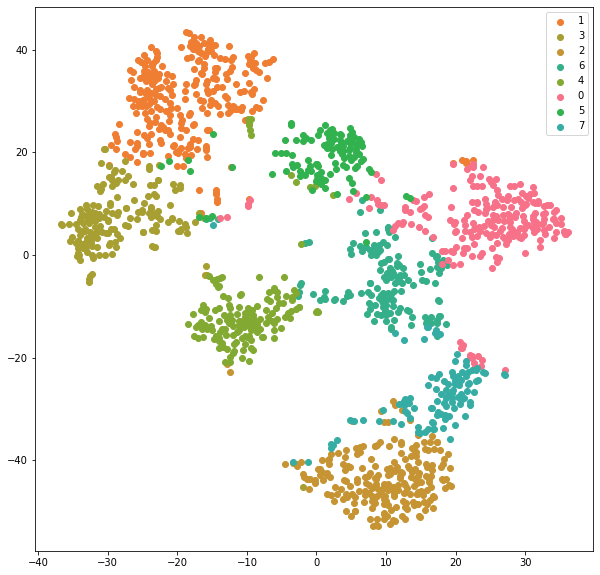

In [74]:
clusters = KMeans(n_clusters = 8, random_state=42)
clusters.fit(embeddings)

embeddings_df["cluster_label2"] = clusters.labels_

u_labels = embeddings_df["cluster_label2"].unique()
rgb_values = sns.color_palette("husl", 14)
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["cluster_label2"]==i]["embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["cluster_label2"]==i]["embeddings_2d"].tolist())[:,1] , label = i, color=rgb_values[i])
plt.legend()
plt.show()

Still works well (but now without outlier detection)

# Task 3

Here we try to perform classification with gradient boosting.

In [ ]:
X = embeddings_df["embeddings"].tolist()
y = embeddings_df["gt_labelnum"].tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.045, random_state=42)

In [ ]:
clf = GradientBoostingClassifier(n_estimators=8, random_state=42).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4,5,6,7])
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(conf_matrix)

In [ ]:
accuracy_score(y_pred, y_test)

In [ ]:
f1_score(y_pred, y_test, average = "weighted")

# Conclusion

Arcface gives even better feature results, then conventional CNN. It is much easier to remove the outliers with ArcFace and OPTICS.

The ideas for main improvement are provided in the first part of the task. The majority of them may be applied to the ArcFace baseline.